In [241]:
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Helper to load a file like rho_out.txt
def load_field(filename):
    data = []
    zs = []
    with open(filename) as f:
        lines = f.readlines()
    i = 0
    while i < len(lines):
        # skip empty lines
        if not lines[i].strip():
            i += 1
            continue
        # first line is z
        z = float(lines[i].strip())
        zs.append(z)
        i += 1
        # next N lines until blank
        block = []
        while i < len(lines) and lines[i].strip():
            row = list(map(float, lines[i].split()))
            block.append(row)
            i += 1
        data.append(block)
    return np.array(zs), np.array(data)  # zs: (K,), data: (K, N, M)

In [223]:
# Body radius function
def r_b(z):
    return np.tan(np.pi/12) * np.sqrt(2*z - 1)
    return np.tan(np.pi/12) * z

In [33]:
def distribution_plot(f_name):
    f_dict = {
        'p': p,
        'rho': rho,
        'u': u,
        'v': v,
        'w': w
    }
    f_cone_dict = {
        'p': p_cone,
        'rho': rho_cone,
        'u': np.sin(phi_cone)*VR_cone + np.cos(phi_cone)*Vtheta_cone,
        'v': np.zeros_like(p_cone),
        'w': np.cos(phi_cone)*VR_cone - np.sin(phi_cone)*Vtheta_cone
    }
    fig, ax = plt.subplots(figsize=(15,9))
    vmin = min(np.min(f_dict[f_name]), np.min(f_cone_dict[f_name]))
    vmax = max(np.max(f_dict[f_name]), np.max(f_cone_dict[f_name]))
    pcm = ax.pcolormesh(
        np.tile(zs, (N, 1)).T,
        r_phys,
        f_dict[f_name][:,:,0],
        shading='auto',
        cmap='plasma',
        vmin=vmin,
        vmax=vmax
    )
    pcm = ax.pcolormesh(
        np.tile(zs, (N, 1)).T,
        -r_phys,
        f_dict[f_name][:,:,-1],
        shading='auto',
        cmap='plasma',
        vmin=vmin,
        vmax=vmax
    )
    
    z_cone = np.linspace(0, z0, 200)
    pcm = ax.pcolormesh(
        np.tile(z_cone, (phi_cone.shape[0], 1)),
        np.outer(np.tan(phi_cone), z_cone),
        np.tile(f_cone_dict[f_name], (z_cone.shape[0], 1)).T,
        shading='auto',
        cmap='plasma',
        vmin=vmin,
        vmax=vmax
    )
    pcm = ax.pcolormesh(
        np.tile(z_cone, (phi_cone.shape[0], 1)),
        -np.outer(np.tan(phi_cone), z_cone), 
        np.tile(f_cone_dict[f_name], (z_cone.shape[0], 1)).T,
        shading='auto',
        cmap='plasma',
        vmin=vmin,
        vmax=vmax
    )
    cbar = fig.colorbar(pcm, ax=ax, label='ρ')
    ax.set_xlabel('z')
    ax.set_ylabel('r')
    plot_label_dict = {
        'p': 'давления p(z,r)',
        'rho': 'плотности ρ(z,r)',
        'u': 'скорости u(z,r)',
        'v': 'скорости v(z,r)',
        'w': 'скорости w(z,r)'
    }
    ax.set_title('Полное распределение ' + plot_label_dict[f_name])
    plt.axvline(x=1.1, linestyle='--')
    plt.show()

In [6]:
# φ и p(φ), ρ(φ), V_R(φ), V_θ(φ)
data_p   = np.loadtxt('p_init.txt')            # shape (L,2): [φ, p]
data_rho = np.loadtxt('rho_init.txt')          # shape (L,2): [φ, ρ]
data_vr_vtheta = np.loadtxt('VR_Vtheta_init.txt')

phi_cone, p_cone = data_p[::-1,0], data_p[::-1,1]
_, rho_cone = data_rho[::-1,0], data_rho[::-1,1]
_, VR_cone, Vtheta_cone = data_vr_vtheta[::-1,0], data_vr_vtheta[::-1,1], data_vr_vtheta[::-1,2]

In [238]:
# Load fields
zs, rho = load_field('rho_out.txt')
_, p = load_field('p_out.txt')
_, u = load_field('u_out.txt')
_, v = load_field('v_out.txt')
_, w = load_field('w_out.txt')
# Load r_s
rs = []
zs_rs = []
with open('r_s_out.txt') as f:
    for line in f:
        parts = list(map(float, line.split()))
        zs_rs.append(parts[0])
        rs.append(parts[1:])
rs = np.array(rs)  # (K, M)
zs_rs = np.array(zs_rs)
z0 = 1

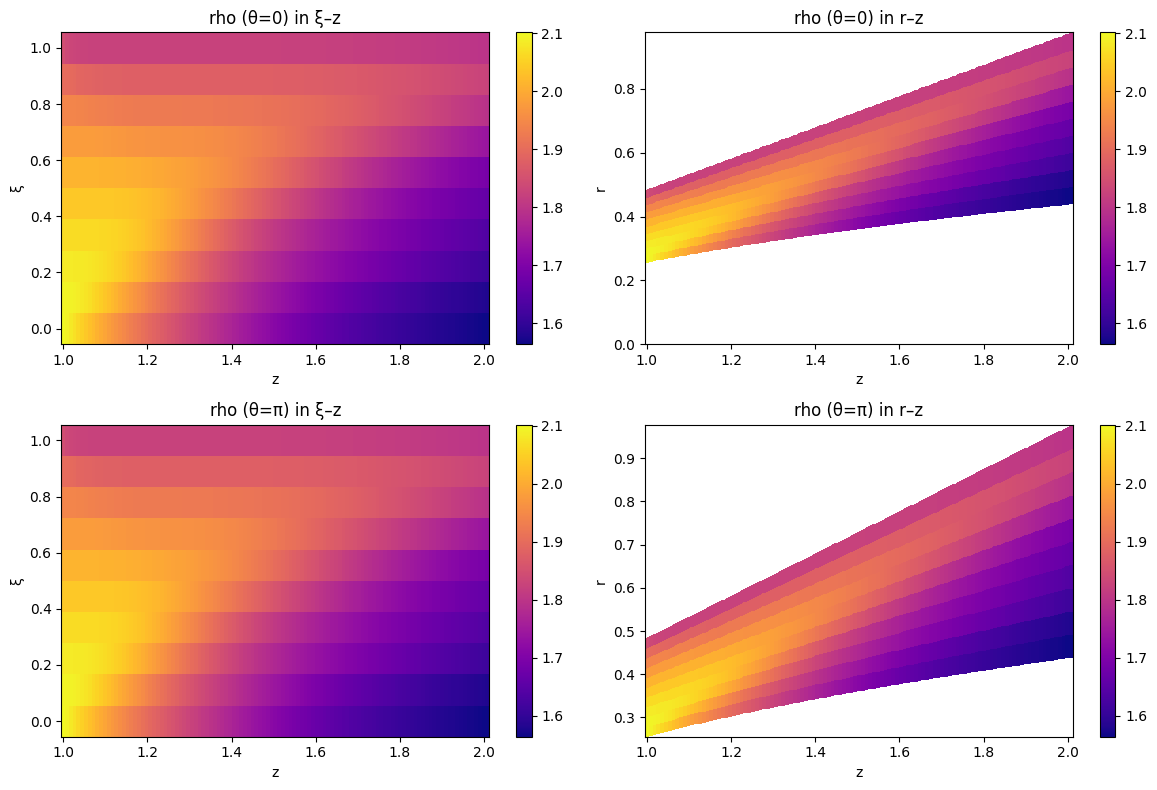

In [379]:
# размеры
K, N, M = rho.shape
xi = np.linspace(0, 1, N)

# срезы по theta
rho_theta0 = rho[:, :, 0]    # (K, N)
rho_thetap = rho[:, :, -1]   # (K, N)

# фигура 2×2
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# 1) ξ–z для θ=0: по X=z, Y=ξ
im0 = axs[0,0].pcolormesh(
    zs,             # X: (K,)
    xi,             # Y: (N,)
    rho_theta0.T,   # C: (N, K)
    shading='auto', cmap='plasma'
)
axs[0,0].set_title('rho (θ=0) in ξ–z')
axs[0,0].set_xlabel('z')
axs[0,0].set_ylabel('ξ')
fig.colorbar(im0, ax=axs[0,0])

# 2) r–z для θ=0: по X=z, Y=r_phys
r_phys = np.zeros_like(rho_theta0)
for k in range(K):
    rb = r_b(zs[k])
    r_phys[k,:] = rb + xi*(rs[k,0] - rb)

im1 = axs[0,1].pcolormesh(
    zs,                # X: (K,)
    xi * 0 + 0,        # dummy Y just to set axes; we'll override below
    rho_theta0.T,      # will not be used
    shading='auto', cmap='plasma'
)
# настоящий pcolormesh с (X,Y,C) всё в одном вызове:
im1 = axs[0,1].pcolormesh(
    zs,               # X: (K,)
    r_phys.T,         # Y: (N,K) as (len(y), len(x))
    rho_theta0.T,     # C: (N, K)
    shading='auto', cmap='plasma'
)
axs[0,1].set_title('rho (θ=0) in r–z')
axs[0,1].set_xlabel('z')
axs[0,1].set_ylabel('r')
fig.colorbar(im1, ax=axs[0,1])

# 3) ξ–z для θ=π
im2 = axs[1,0].pcolormesh(
    zs,
    xi,
    rho_thetap.T,
    shading='auto', cmap='plasma'
)
axs[1,0].set_title('rho (θ=π) in ξ–z')
axs[1,0].set_xlabel('z')
axs[1,0].set_ylabel('ξ')
fig.colorbar(im2, ax=axs[1,0])

# 4) r–z для θ=π
r_phys_p = np.zeros_like(rho_thetap)
for k in range(K):
    rb = r_b(zs[k])
    r_phys_p[k,:] = rb + xi*(rs[k,-1] - rb)

im3 = axs[1,1].pcolormesh(
    zs,
    r_phys_p.T,
    rho_thetap.T,
    shading='auto', cmap='plasma'
)
axs[1,1].set_title('rho (θ=π) in r–z')
axs[1,1].set_xlabel('z')
axs[1,1].set_ylabel('r')
fig.colorbar(im3, ax=axs[1,1])

plt.tight_layout()
plt.show()


In [382]:
def distribution_plot(f_name, stride=1):
    f_dict = {"p": p, "rho": rho, "u": u, "v": v, "w": w}
    f_cone_dict = {
        "p": p_cone,
        "rho": rho_cone,
        "u": np.sin(phi_cone) * VR_cone + np.cos(phi_cone) * Vtheta_cone,
        "v": np.zeros_like(p_cone),
        "w": np.cos(phi_cone) * VR_cone - np.sin(phi_cone) * Vtheta_cone,
    }
    f_init_values = {
        "p": 101330,
        "rho": 1.2255,
        "u": 0,
        "v": 0,
        "w": 3 * np.sqrt(1.4 * 101330 / 1.2255),
    }

    # поля
    F = f_dict[f_name]  # (K,N,M)
    Fc = f_cone_dict[f_name]  # (L,) — по φ

    fig, ax = plt.subplots(figsize=(15, 9))
    # общие границы цвета
    vmin = min(np.nanmin(F[:, :, 0]), np.nanmin(F[:, :, -1]), np.min(Fc))
    vmax = max(np.nanmax(F[:, :, 0]), np.nanmax(F[:, :, -1]), np.max(Fc))
    # 1) pcolormesh расчётной области
    Zg = np.tile(zs, (N, 1)).T  # (K,N)
    pcm = ax.pcolormesh(
        Zg, r_phys, F[:, :, 0], shading="auto", cmap="plasma", vmin=vmin, vmax=vmax
    )
    pcm = ax.pcolormesh(
        Zg, -r_phys, F[:, :, -1], shading="auto", cmap="plasma", vmin=vmin, vmax=vmax
    )
    # 2) pcolormesh конуса
    zc = np.linspace(0, z0, 200)
    Zc = np.tile(zc, (phi_cone.size, 1))
    Rc = np.outer(np.tan(phi_cone), zc)
    pcm = ax.pcolormesh(
        Zc,
        Rc,
        np.tile(Fc, (zc.size, 1)).T,
        shading="auto",
        cmap="plasma",
        vmin=vmin,
        vmax=vmax,
    )
    pcm = ax.pcolormesh(
        Zc,
        -Rc,
        np.tile(Fc, (zc.size, 1)).T,
        shading="auto",
        cmap="plasma",
        vmin=vmin,
        vmax=vmax,
    )

    z_background = np.tile(zs, reps=(100, 1))
    t = np.linspace(0, 1, 100)  # shape (N,)
    # затем строим B[i,j] = a[j] + t[i] * (2 - a[j]):
    rs_background = rs[:, 0][np.newaxis, :] + t[:, np.newaxis] * (
        1 - rs[:, 0][np.newaxis, :]
    )
    z_cone_background = np.tile(np.linspace(0, 1), reps=(100, 1))
    rs_cone_background = np.tan(phi_cone[-1]) * np.linspace(0, 1)[np.newaxis, :] + t[
        :, np.newaxis
    ] * (1 - np.tan(phi_cone[-1]) * np.linspace(0, 1)[np.newaxis, :])

    pcm = ax.pcolormesh(
        z_background,
        rs_background,
        f_init_values[f_name] * np.ones_like(rs_background),
        shading="auto",
        cmap="plasma",
        vmin=vmin,
        vmax=vmax,
    )
    pcm = ax.pcolormesh(
        z_background,
        -rs_background,
        f_init_values[f_name] * np.ones_like(rs_background),
        shading="auto",
        cmap="plasma",
        vmin=vmin,
        vmax=vmax,
    )
    pcm = ax.pcolormesh(
        z_cone_background,
        rs_cone_background,
        f_init_values[f_name] * np.ones_like(rs_cone_background),
        shading="auto",
        cmap="plasma",
        vmin=vmin,
        vmax=vmax,
    )
    pcm = ax.pcolormesh(
        z_cone_background,
        -rs_cone_background,
        f_init_values[f_name] * np.ones_like(rs_cone_background),
        shading="auto",
        cmap="plasma",
        vmin=vmin,
        vmax=vmax,
    )

    # легенды и подписи
    plot_label_dict = {
        "p": "давления p(z,r)",
        "rho": "плотности ρ(z,r)",
        "u": "скорости u(z,r)",
        "v": "скорости v(z,r)",
        "w": "скорости w(z,r)",
    }
    cbar = fig.colorbar(pcm, ax=ax, label=plot_label_dict[f_name])
    ax.set_xlabel("z")
    ax.set_ylabel("r")
    ax.set_title("Полное распределение " + plot_label_dict[f_name])
    ax.axvline(x=z0, linestyle="--", color="k")
    plt.plot(
        np.hstack((np.linspace(0, z0), zs)),
        np.hstack((np.tan(phi_cone[-1]) * np.linspace(0, z0), rs[:, 0])),
        linewidth=3,
        color="white",
    )
    plt.plot(
        np.hstack((np.linspace(0, z0), zs)),
        np.hstack((-np.tan(phi_cone[-1]) * np.linspace(0, z0), -rs[:, -1])),
        linewidth=3,
        color="white",
    )
    plt.show()

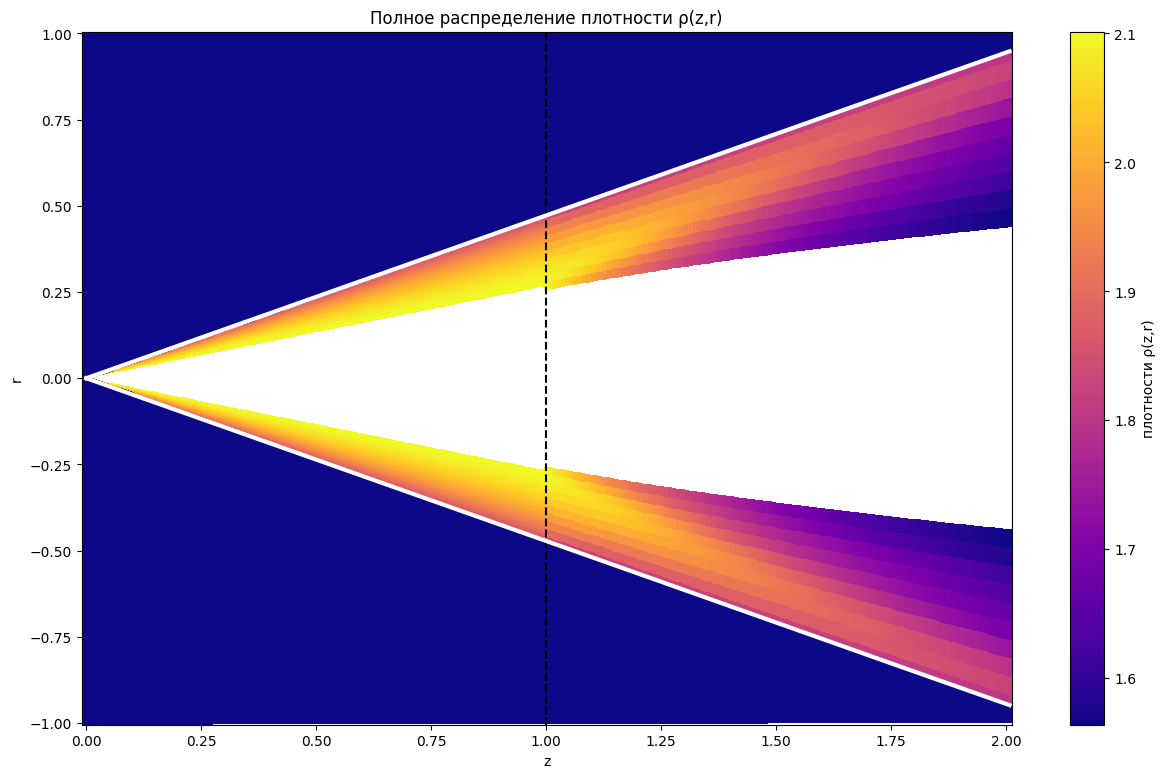

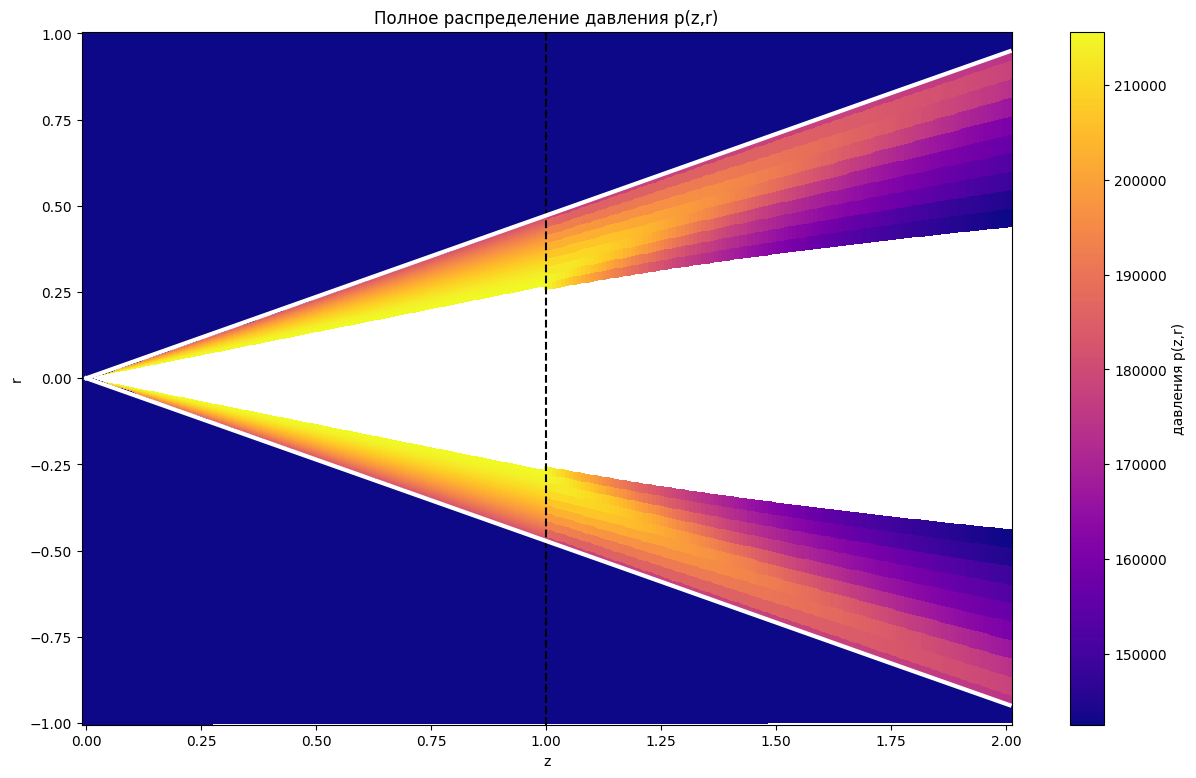

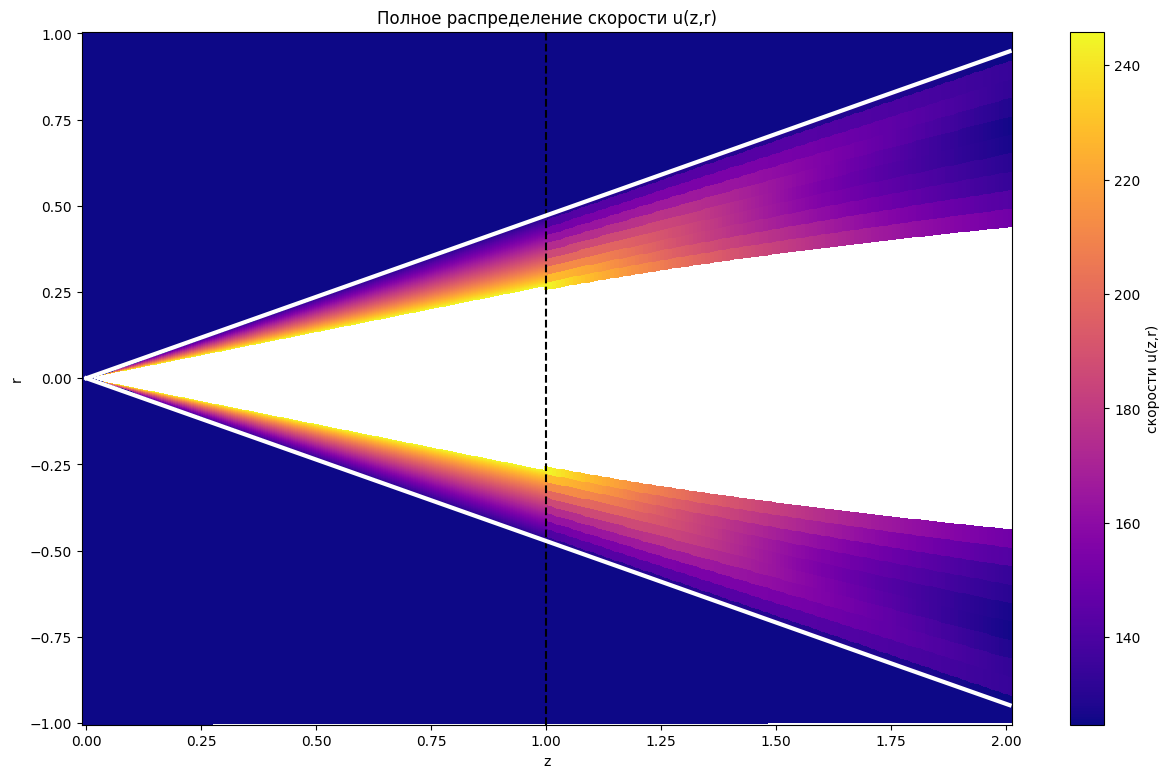

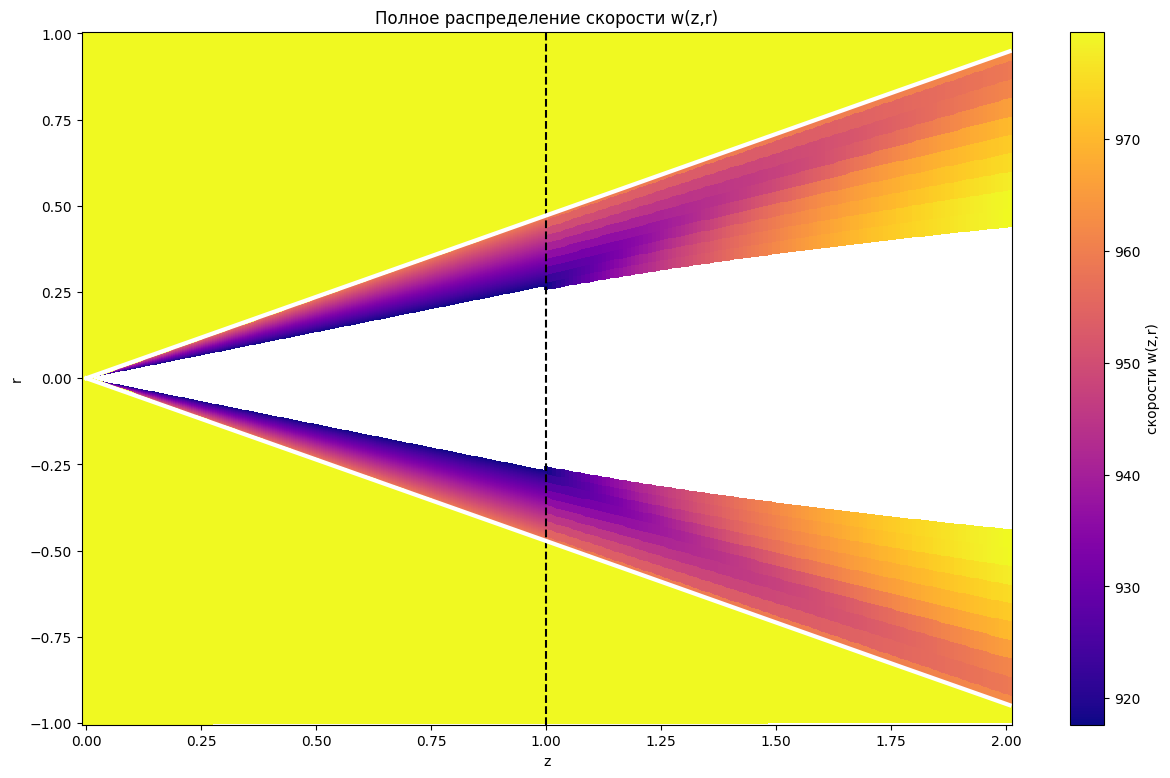

In [383]:
for func in ['rho', 'p', 'u', 'w']:
    distribution_plot(func)

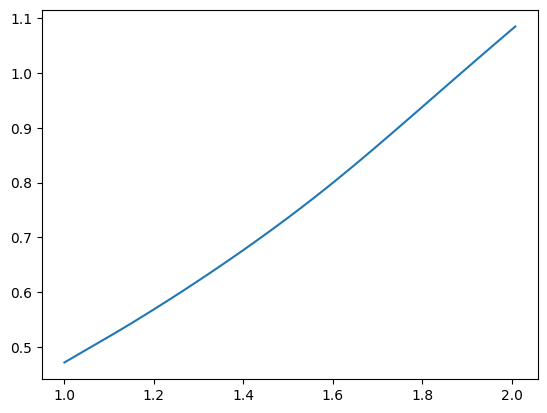

In [9]:
plt.plot(zs, rs[:,-1])

In [370]:
def load_streamfunc(filename):
    zs, psi = [], []
    i = 0
    with open(filename) as f:
        for line in f:
            if i % 2 == 0:
                zs.append(float(line))
            else:
                psi.append(list(map(float, line.split())))
            i += 1
    return np.array(zs), np.array(psi)  # zs: (K,), psi: (K,N)

zs0, psi0 = load_streamfunc('psi0_out.txt')
zsp, psip = load_streamfunc('psi1_out.txt')

f_cone_dict = {
        'p': p_cone,
        'rho': rho_cone,
        'u': np.sin(phi_cone)*VR_cone + np.cos(phi_cone)*Vtheta_cone,
        'v': np.zeros_like(p_cone),
        'w': np.cos(phi_cone)*VR_cone - np.sin(phi_cone)*Vtheta_cone
}

z_cone = np.tile(np.linspace(0, z0, 100), (phi_cone.shape[0], 1)).T

r_cone = np.outer(np.linspace(0, z0, 100), np.tan(phi_cone))

rho_cone_tile = np.tile(f_cone_dict['rho'], (100, 1))
u_cone_tile = np.tile(f_cone_dict['u'], (100, 1))

dr_cone = np.hstack((np.zeros((100, 1)), np.diff(r_cone, axis=1)))

psi_cone = np.cumsum(rho_cone_tile * u_cone_tile * r_cone * dr_cone, axis=1)

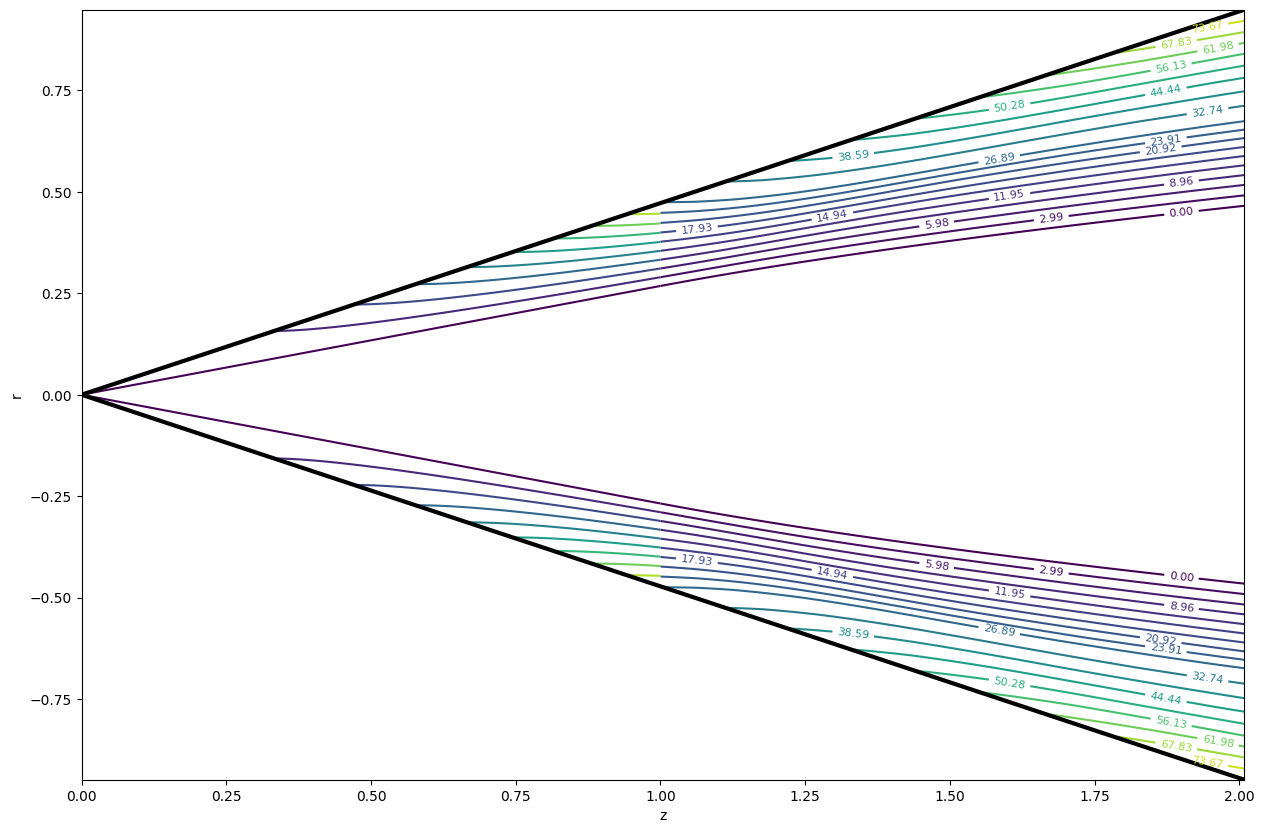

In [385]:
fig, ax = plt.subplots(figsize=(15, 10))
levels_cone = np.linspace(psi_cone.min(), psi_cone.max(), 10)
levels_0 = np.unique(
    np.clip(
        np.hstack((levels_cone, np.linspace(psi_cone.max(), psi0.max(), 10))),
        a_min=psi0.min(),
        a_max=psi0.max(),
    )
)
levels_1 = np.unique(
    np.clip(
        np.hstack((levels_cone, np.linspace(psi_cone.max(), psip.max(), 10))),
        a_min=psip.min(),
        a_max=psip.max(),
    )
)
cs0 = ax.contour(Z, R0, psi0, levels=levels_0, linestyles="-")
csp = ax.contour(Z, Rp, psip, levels=levels_1, linestyles="-")
cs_cone_0 = ax.contour(z_cone, r_cone, psi_cone, levels=levels_cone, linestyles="-")
cs_cone_p = ax.contour(z_cone, -r_cone, psi_cone, levels=levels_cone, linestyles="-")
ax.clabel(cs0, inline=True, fontsize=8)
ax.clabel(csp, inline=True, fontsize=8)
ax.set_xlabel("z")
ax.set_ylabel("r")
# ax.legend([cs0.collections[0], csp.collections[0]], ['θ=0','θ=π'])
plt.plot(
    np.hstack((np.linspace(0, z0), zs)),
    np.hstack((np.tan(phi_cone[-1]) * np.linspace(0, z0), rs[:, 0])),
    linewidth=3,
    color="black",
)
plt.plot(
    np.hstack((np.linspace(0, z0), zs)),
    np.hstack((-np.tan(phi_cone[-1]) * np.linspace(0, z0), -rs[:, -1])),
    linewidth=3,
    color="black",
)
plt.show()

In [10]:
(rs[1,-1] - rs[0,-1]) / (zs[1] - zs[0])

0.47411111111111887

In [11]:
(rs[-1,-1] - rs[-2,-1]) / (zs[-1] - zs[-2])

0.695555555555556

In [386]:
def f(a=1, b=2):
    return a + b

In [388]:
f()

3

In [389]:
dictt = {'a': 2, 'b': 4}

In [390]:
f(**dictt)

6